<a href="https://colab.research.google.com/github/tejaswaroop2310/Face-Emotion-Recognition/blob/main/facial_expression_classification_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
#import Libraries

import numpy as np 
import pandas as pd 

from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



# dataset 

In [2]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Read the data
df = pd.read_csv('/content/drive/MyDrive/Capstone Project  5/fer2013.csv')
#check df shape
df.shape

(35887, 3)

In [4]:
# view first 5 rows of data
df.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
#check usage values

df.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [6]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']

emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


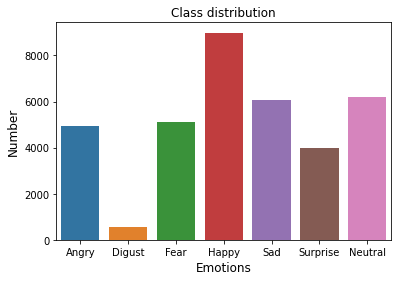

In [7]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

Looking at some images from the dataset...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) 

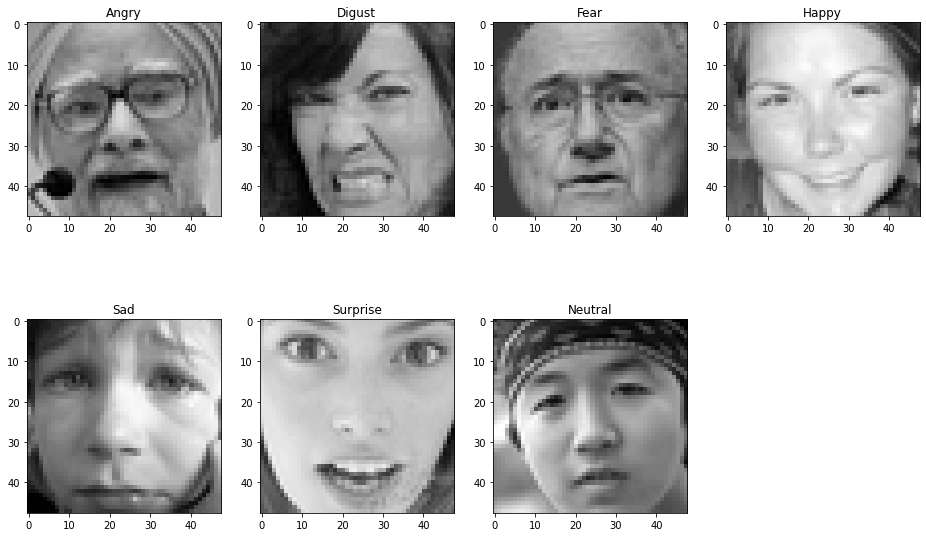

In [8]:
#Convert Row into Image
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = df[df['emotion'] == i-1].iloc[1]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

# Pre-processing Data

In [11]:
def load_data(dataset_path): #Run once
  
  #We will be dealing with seven different types of emotions.

  data = []
  test_data = []
  test_labels = []
  labels =[]

  with open(dataset_path, 'r') as file:
      for line_no, line in enumerate(file.readlines()):
          if 0 < line_no <= 35887:
            curr_class, line, set_type = line.split(',')
            image_data = np.asarray([int(x) for x in line.split()]).reshape(48, 48)#Creating a list out of the string then converting it into a 2-Dimensional numpy array.
            image_data =image_data.astype(np.uint8)/255.0
            
            if (set_type.strip() == 'PrivateTest'):
              
              test_data.append(image_data)
              test_labels.append(curr_class)
            else:
              data.append(image_data)
              labels.append(curr_class)
      
      test_data = np.expand_dims(test_data, -1)
      test_labels = to_categorical(test_labels, num_classes = 7)
      data = np.expand_dims(data, -1)   
      labels = to_categorical(labels, num_classes = 7)
    
      return np.array(data), np.array(labels), np.array(test_data), np.array(test_labels)

In [12]:
#Split the data
dataset_path = "/content/drive/MyDrive/Capstone Project  5/fer2013.csv"
train_data, train_labels, test_data, test_labels = load_data(dataset_path)


print("Number of images in Training set:", len(train_data))
print("Number of images in Test set:", len(test_data))

Number of images in Training set: 32298
Number of images in Test set: 3589


# Building CNN Model
**CNN Architecture**

    

In [13]:
#Import Libraries
from tensorflow.keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint


In [14]:
#Building the Model
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D
from keras.models import Sequential

model = Sequential()

model.add(Convolution2D(64, (3, 1), padding='same', input_shape=(48,48,1)))
model.add(Convolution2D(64, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Convolution2D(128, (3, 1), padding='same'))
model.add(Convolution2D(128, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Convolution2D(256, (3, 1), padding='same'))
model.add(Convolution2D(256, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Convolution2D(512, (3, 1), padding='same'))
model.add(Convolution2D(512, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        256       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        12352     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0

In [15]:
from keras.preprocessing.image import ImageDataGenerator 

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,   # randomly flip images
    )


datagen.fit(train_data)
datagen.fit(test_data)

In [16]:
batch_size = 32

num_epochs = 50

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

filepath='/content/drive/MyDrive/Capstone Project  5/weight.hd5'
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')



In [18]:
#Compile the model
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=[ 'acc'])

In [19]:
train_flow = datagen.flow(train_data, train_labels, batch_size=batch_size)
validation_flow = datagen.flow(test_data, test_labels)

In [20]:
%%time
#Fit the model
history = model.fit_generator(train_flow,
                    steps_per_epoch=len(train_data) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=validation_flow, 
                    validation_steps=len(test_data) / batch_size,
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
1009/1009 [==============================] - 66s 53ms/step - loss: 1.6692 - acc: 0.3493 - val_loss: 1.3915 - val_acc: 0.4452
Epoch 2/50
1009/1009 [==============================] - 50s 49ms/step - loss: 1.3571 - acc: 0.4793 - val_loss: 1.3511 - val_acc: 0.4659
Epoch 3/50
1009/1009 [==============================] - 49s 49ms/step - loss: 1.2593 - acc: 0.5215 - val_loss: 1.2303 - val_acc: 0.5222
Epoch 4/50
1009/1009 [==============================] - 49s 49ms/step - loss: 1.2095 - acc: 0.5399 - val_loss: 1.3331 - val_acc: 0.4589
Epoch 5/50
1009/1009 [==============================] - 49s 49ms/step - loss: 1.1788 - acc: 0.5547 - val_loss: 1.1117 - val_acc: 0.5821
Epoch 6/50
1009/1009 [==============================] - 49s 49ms/step - loss: 1.1484 - acc: 0.5629 - val_loss: 1.1000 - val_acc: 0.5773
Epoch 7/50
1009/1009 [==============================] - 50s 49ms/step - loss: 1.1280 - acc: 0.5695 - val_loss: 1.1475 - val_acc: 0.5662
Epoch 8/50
1009/1009 [==========================

# Visualise training performance

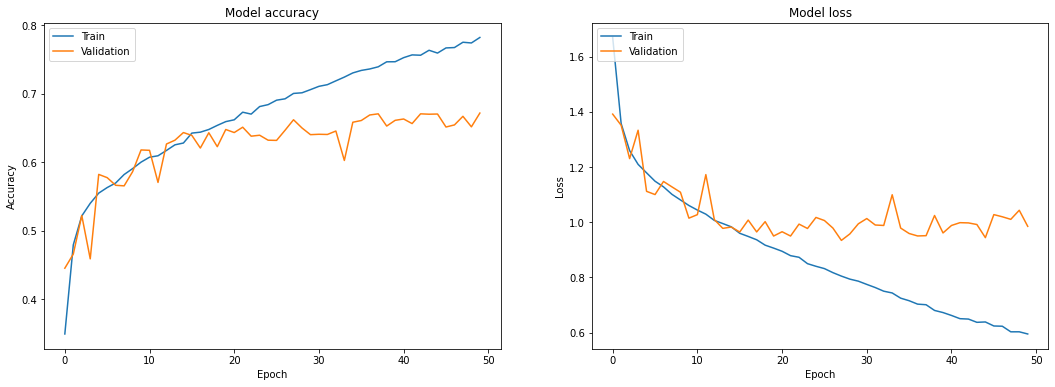

In [21]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['acc'])
axes[0].plot(history.history['val_acc'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate Test performance

In [22]:
#Accuracy Score
predicted_test_labels = np.argmax(model.predict(test_data), axis=1)
test_labels = np.argmax(test_labels, axis=1)
print ("Accuracy score = ", accuracy_score(test_labels, predicted_test_labels))
print ("Accuracy percentage = ", accuracy_score(test_labels, predicted_test_labels)*100, "%")


Accuracy score =  0.673725271663416
Accuracy percentage =  67.3725271663416 %


# Confusion Matrix

In [25]:

labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [26]:
#Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    plt.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


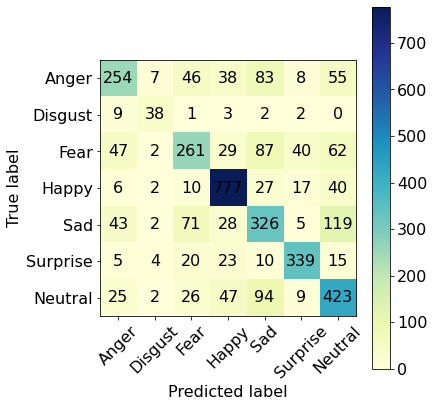

In [27]:
plot_confusion_matrix(test_labels, predicted_test_labels, cmap=plt.cm.YlGnBu)
plt.show()

In [28]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted_test_labels, target_names=labels))

              precision    recall  f1-score   support

       Anger       0.65      0.52      0.58       491
     Disgust       0.67      0.69      0.68        55
        Fear       0.60      0.49      0.54       528
       Happy       0.82      0.88      0.85       879
         Sad       0.52      0.55      0.53       594
    Surprise       0.81      0.81      0.81       416
     Neutral       0.59      0.68      0.63       626

    accuracy                           0.67      3589
   macro avg       0.67      0.66      0.66      3589
weighted avg       0.67      0.67      0.67      3589



In [29]:
from keras.models import model_from_json
model_json = model.to_json()
with open("/content/drive/MyDrive/Capstone Project  5/mainfinal1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/Capstone Project  5/mainfinal1.hdf5")
print("Saved model to disk")

Saved model to disk


In [30]:
# Saving the whole model along with architecture in FER_model.h5
model.save('/content/drive/MyDrive/Capstone Project  5/mainfinal1.h5')
print('Model Saved')

Model Saved
